In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor


In [2]:
df = pd.read_csv('boxoffice.csv')
df.describe().T
df.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,The Avengers,6026491,1274885664,Warner Bros.,163620146,253,174687337,R,Animation,16
1,Titanic,169411543,1132871091,Disney,85549990,122,103948486,G,Action,103
2,Jurassic Park,107836098,583329845,Sony,55681429,3826,122104991,NC-17,Horror,89
3,Avatar,51433697,1225323391,Disney,109775324,3868,46431596,G,Horror,85
4,The Lion King,142791649,604140729,Warner Bros.,59476800,2934,203513696,R,Comedy,158


In [3]:
# We will be predicting only
# domestic_revenue in this article.
df.drop(['world_revenue', 'opening_revenue'], axis=1, inplace=True)
df.head()

,title,domestic_revenue,distributor,opening_theaters,budget,MPAA,genres,release_days
0,The Avengers,6026491,Warner Bros.,253,174687337,R,Animation,16
1,Titanic,169411543,Disney,122,103948486,G,Action,103
2,Jurassic Park,107836098,Sony,3826,122104991,NC-17,Horror,89
3,Avatar,51433697,Disney,3868,46431596,G,Horror,85
4,The Lion King,142791649,Warner Bros.,2934,203513696,R,Comedy,158


In [4]:
#null values
print(df.isnull().sum())
df.shape

title               0
domestic_revenue    0
distributor         0
opening_theaters    0
budget              0
MPAA                0
genres              0
release_days        0
dtype: int64


(2694, 8)

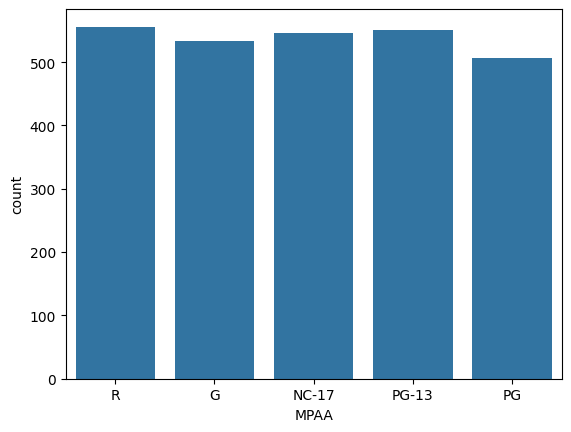

In [5]:
# a bar graph
plt.Figure(figsize=(10, 8))
sb.countplot(x='MPAA', data=df)
plt.show()

In [6]:
#grouping MPAA based on domestic revenue
df.groupby('MPAA')['domestic_revenue'].mean().sort_values(ascending=False)

MPAA
R        1.563334e+08
PG       1.529123e+08
NC-17    1.507193e+08
PG-13    1.477556e+08
G        1.465288e+08
Name: domestic_revenue, dtype: float64

C:\Users\User\AppData\Local\Temp\ipykernel_2896\2071189437.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df[col])
C:\Users\User\AppData\Local\Temp\ipykernel_2896\2071189437.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df[col])
C:\Users\User\AppData\Local\Temp\ipykernel_2896\2071189437

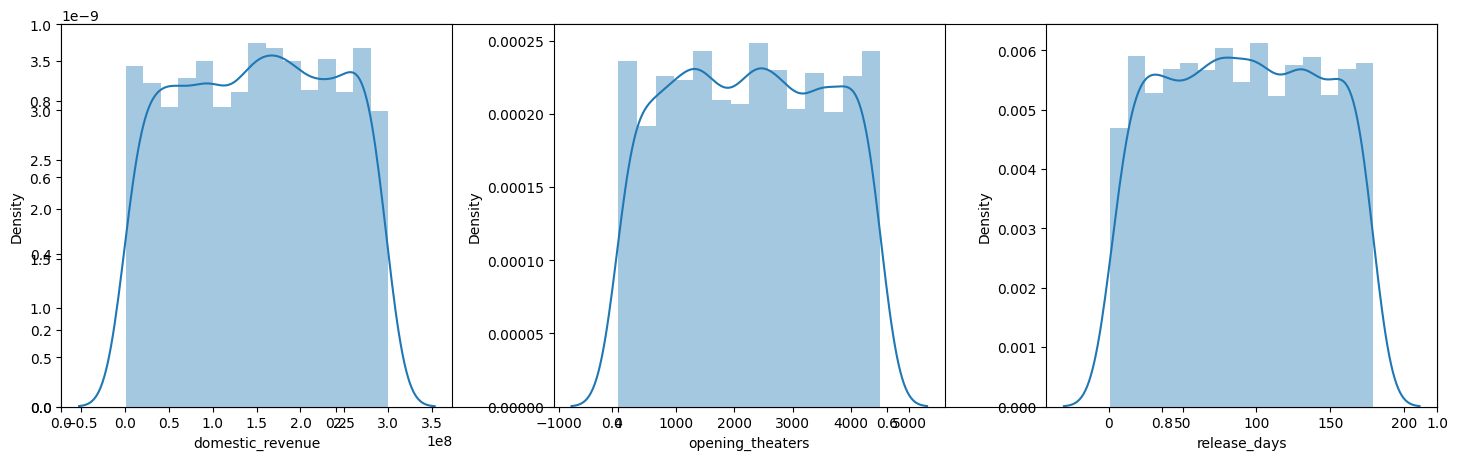

In [7]:
plt.subplots(figsize=(15, 5))

features = ['domestic_revenue', 'opening_theaters', 'release_days']
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.distplot(df[col])
plt.tight_layout()
plt.show()

In [8]:
for col in features:
    df[col] = df[col].apply(lambda x: np.log10(x))

In [9]:
#converting genre strings into binary
vectorizer = CountVectorizer()
vectorizer.fit(df['genres'])
features = vectorizer.transform(df['genres']).toarray()

genres = vectorizer.get_feature_names_out()
for i, name in enumerate(genres):
	df[name] = features[:, i]

df.drop('genres', axis=1, inplace=True)
df.head()

,title,domestic_revenue,distributor,opening_theaters,budget,MPAA,release_days,action,animation,comedy,drama,horror,thriller
0,The Avengers,6.780065,Warner Bros.,2.403121,174687337,R,1.204120,0,1,0,0,0,0
1,Titanic,8.228943,Disney,2.086360,103948486,G,2.012837,1,0,0,0,0,0
2,Jurassic Park,8.032764,Sony,3.582745,122104991,NC-17,1.949390,0,0,0,0,1,0
3,Avatar,7.711248,Disney,3.587486,46431596,G,1.929419,0,0,0,0,1,0
4,The Lion King,8.154703,Warner Bros.,3.467460,203513696,R,2.198657,0,0,1,0,0,0


In [10]:
#converting characters and string s into numerics
for col in ['distributor', 'MPAA']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
df.head(10)    

,title,domestic_revenue,distributor,opening_theaters,budget,MPAA,release_days,action,animation,comedy,drama,horror,thriller
0,The Avengers,6.780065,4,2.403121,174687337,4,1.204120,0,1,0,0,0,0
1,Titanic,8.228943,0,2.086360,103948486,0,2.012837,1,0,0,0,0,0
2,Jurassic Park,8.032764,2,3.582745,122104991,1,1.949390,0,0,0,0,1,0
3,Avatar,7.711248,0,3.587486,46431596,0,1.929419,0,0,0,0,1,0
4,The Lion King,8.154703,4,3.467460,203513696,4,2.198657,0,0,1,0,0,0
5,Star Wars,8.452948,3,3.084934,39257068,4,2.187521,0,0,1,0,0,0
6,Frozen,7.576806,2,3.650502,81033758,1,1.672098,1,0,0,0,0,0
7,Inception,8.267783,1,3.549984,299859703,3,1.643453,0,0,0,1,0,0
8,The Dark Knight,8.375986,4,3.258398,185463573,4,0.954243,1,0,0,0,0,0
9,Harry Potter,6.590078,3,3.162564,20168236,2,2.181844,0,0,0,0,1,0


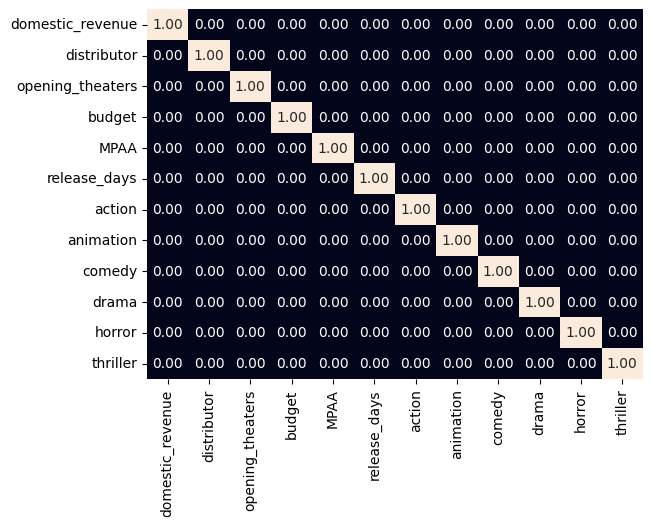

In [11]:
#plotting a scatter plot
plt.Figure(figsize=(8,8))
sb.heatmap(df.select_dtypes(include=np.number).corr()>0.8,
           fmt='.2f',
           annot=True,
           cbar=False)
plt.show()

In [12]:
#preparing data for model training and validation
#we will remove the title and target column(domestic_revenue)
#we shall split the data into 90% training and 10% validation to ensure better model performance
features = df.drop(['title', 'domestic_revenue'], axis=1)
target = df['domestic_revenue'].values

x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.1, random_state=22)
x_train.shape, x_val.shape

((2424, 11), (270, 11))

In [13]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
X_val = scaler.transform(x_val)

In [14]:
#training the xgboost regression model
from sklearn.metrics import mean_absolute_error as mae
model = XGBRegressor()
model.fit(x_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [15]:
# Evaluating the model performance on training and validation sets
train_preds = model.predict(x_train)
print('Training Error : ', mae(y_train, train_preds))

val_preds = model.predict(x_val)
print('Validation Error : ', mae(y_val, val_preds))
print()

Training Error :  0.0944548896789596
Validation Error :  0.4426430279699183

